In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from multi_group_simulation import MultiGroupSimulation
from stochastic_simulation import StochasticSimulation
from load_params import load_params

In [2]:
def single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing):
    base_config_loc="/home/jmc678/covid_data/group-testing/src/simulations_v2/params/"\
                "june8params/noreopen/nominal_students.yaml"
    _, base_config = load_params(base_config_loc)
    base_config['test_population_fraction'] = test_rate
    base_config['expected_contacts_per_day'] = daily_contacts
    base_config['population_size'] = pop_size
    base_config['daily_outside_infection_p'] = outside_infection_p
    base_config['init_ID_prevalence_stochastic'] = True
    base_config['perform_contact_tracing'] = perform_contact_tracing
    return base_config

def multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing, num_groups):
    base_configs = [single_group_config(pop_size / num_groups, 
                                        daily_contacts / num_groups, 
                                        test_rate, 
                                        outside_infection_p,
                                        perform_contact_tracing)] * num_groups
    interaction_matrix = np.matrix([[daily_contacts/num_groups] * num_groups] * num_groups)
    return base_configs, interaction_matrix

In [4]:
pop_size = 1000
daily_contacts = 10
test_rate = 0.2
outside_infection_p = 1.2e-5

num_groups = 10

single_grp_sim = StochasticSimulation(single_group_config(pop_size, 
                                                          daily_contacts, 
                                                          test_rate, 
                                                          False, 
                                                          outside_infection_p))

configs, interaction_mtx = multi_group_config(pop_size, 
                                              daily_contacts, 
                                              test_rate, 
                                              outside_infection_p, 
                                              False, 
                                              num_groups)
multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_popsize(df):
    cols = df.columns
    subdf = df[[col for col in cols if 'cumulative' not in col]]
    return subdf.sum(axis=1).iloc[0]

def infection_pct(df):
    popsize = get_popsize(df)
    
    subdf = df[['cumulative_mild', 'cumulative_severe']]
    infections = subdf.sum(axis=1).iloc[-1]
    
    return infections / popsize * 100

def add_df_plot(df, label, color, alpha=0.1, linewidth=10):
    popsize = get_popsize(df)
    df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1) \
                        .plot(label=label, alpha=alpha, linewidth=linewidth, color=color)

In [6]:
import time

pop_size = 1000
daily_contacts = 10
test_rate = 0.2
outside_infection_p = 1.2e-5

num_groups = 10

ntrajectories=5

start = time.time()

single_grp_sim = StochasticSimulation(single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, False))
single_grp_dfs = []
for _ in range(ntrajectories):
    single_grp_dfs.append(single_grp_sim.run_new_trajectory(112))

multi_grp_dfs = []
configs, interaction_mtx = multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, False, num_groups)
multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)
for _ in range(ntrajectories):
    multi_grp_dfs.append(multi_grp_sim.run_new_trajectory(112))
    
end = time.time()

print("elapsed time = {:.2f}".format(end-start))

elapsed time = 30.86


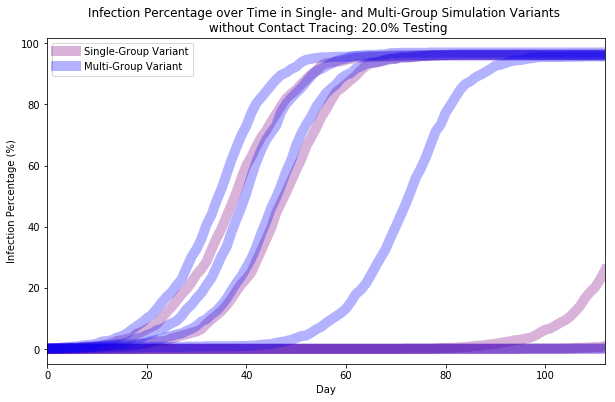

In [7]:
plt.figure(figsize=(10,6))
label='Single-Group Variant'
for df in single_grp_dfs:
    add_df_plot(df, label=label, color='purple', alpha=0.3, linewidth=10)
    label=''

label='Multi-Group Variant'
for df in multi_grp_dfs:
    add_df_plot(df, label=label, color='blue', alpha=0.3, linewidth=10)
    label=''

plt.xlabel("Day")
plt.ylabel("Infection Percentage (%)")
plt.legend()
plt.title("Infection Percentage over Time in Single- and Multi-Group Simulation Variants \n without Contact Tracing: {}% Testing".format(test_rate * 100))
plt.show()

In [ ]:
import multiprocessing

def run_parallel_trajectories()